# How To Fine-Tune Decoder-Only Models?

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Brain_Dump-red)
![Tag](https://img.shields.io/badge/Level-Beginner-green)
[![Code](https://img.shields.io/badge/View-Code-blue?style=flat-square&logo=github)](https://github.com/gao-hongnan/omniverse/tree/main/omnivault/transformer)

```{contents}
:local:
```

Firstly, if you have not read my
[Generative Pre-trained Transformers (GPT) series](https://www.gaohongnan.com/influential/generative_pretrained_transformer/03_concept.html),
please have a read first to establish some basic understand on what a
decoder-only model entails.

## Dependencies

In [1]:
from __future__ import annotations

from functools import partial
from typing import List, Tuple
from rich.pretty import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from IPython.display import clear_output

from omnivault.transformer.config.composer import Composer
from omnivault.transformer.config.criterion import CRITERION_REGISTRY
from omnivault.transformer.config.decoder import (
    AddNormConfig,
    DecoderBlockConfig,
    DecoderConfig,
    MultiHeadedAttentionConfig,
    PositionwiseFeedForwardConfig,
)
from omnivault.transformer.config.generator import GeneratorConfig
from omnivault.transformer.config.optim import OPTIMIZER_REGISTRY
from omnivault.transformer.config.scheduler import SCHEDULER_REGISTRY
from omnivault.transformer.config.trainer import TrainerConfig
from omnivault.transformer.core.state import State
from omnivault.transformer.core.trainer import Trainer, TrainerEvent
from omnivault.transformer.decoder.core import GPTDecoder, GPTDecoderBlock
from omnivault.transformer.modules.attention.core import ScaledDotProductAttention
from omnivault.utils.reproducibility.seed import seed_all

## Reproducibility

In [2]:
seed_all(seed=2024, seed_torch=True, set_torch_deterministic=False)

2024

## Constructing A Reversal Dataset

We first start with a simple enough dataset that we can use to fine-tune a 
decoder on. The dataset is a simple reversal dataset, where we have a sequence
of integers.

In [3]:
class ReverseDataset(Dataset):

    def __init__(self, num_classes: int, seq_len: int, num_samples: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.seq_len = seq_len
        self.num_samples = num_samples

        self.data = torch.randint(self.num_classes, size=(self.num_samples, self.seq_len))

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        input_ids = self.data[index]
        labels = torch.flip(input_ids, dims=(0,))
        return input_ids, labels

In [4]:
seed_all(seed=42, seed_torch=True, set_torch_deterministic=False)

SEQ_LEN, NUM_CLASSES, BATCH_SIZE = 4, 10, 128
TRAIN_SAMPLES, VALID_SAMPLES     = 50000, 10000

dataset      = partial(ReverseDataset, num_classes=NUM_CLASSES, seq_len=SEQ_LEN)
train_loader = DataLoader(dataset(num_samples=TRAIN_SAMPLES), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(dataset(num_samples=VALID_SAMPLES), batch_size=BATCH_SIZE)

input_ids, labels = next(iter(train_loader))
assert input_ids.shape == labels.shape == (BATCH_SIZE, SEQ_LEN) == (128, 4)
print(f"Input[0]: {input_ids[0]}\nLabel[0]: {labels[0]}")

Input[0]: tensor([6, 0, 2, 1])
Label[0]: tensor([1, 2, 0, 6])


Now, notice we are missing the causal masks, which we will define in the next
section. The "better" way is to define it in the return statement of the
`__getitem__` method, but it was not done here due to legacy issues (i.e. my
first time implementing a decoder model from scratch).

In [5]:
def construct_dummy_batch_future_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Broadcast future mask from shape (L, L) to (B, L, L) then (B, 1, L, L)."""
    # Create a lower triangular mask for a single sequence
    future_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=0).to(torch.bool)
    future_mask = future_mask.contiguous()
    # broadcast future mask from shape (L, L) to (B, L, L)
    future_masks = future_mask.unsqueeze(0).expand(batch_size, -1, -1)
    # broadcast future mask from shape (B, L, L) to (B, 1, L, L)
    future_masks = future_masks.unsqueeze(1)
    return torch.BoolTensor(future_masks)

def construct_dummy_batch_target_padding_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Construct a dummy batch of target padding masks of shape (B, 1, L, L) which
    assumes there is no padding token involved."""

    return torch.BoolTensor(torch.ones((batch_size, 1, seq_len, seq_len), dtype=torch.bool))

def collate_for_unidirectional(
    batch: List[Tuple[torch.Tensor, torch.Tensor]]
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    sources, targets = zip(*batch)

    sources = torch.stack(sources)
    targets = torch.stack(targets)

    batch_size, seq_len = targets.size(0), targets.size(1)

    future_masks = construct_dummy_batch_future_masks(batch_size, seq_len)
    target_padding_masks = construct_dummy_batch_target_padding_masks(batch_size, seq_len)

    return sources, targets, future_masks, target_padding_masks

In [6]:
seed_all(seed=42, seed_torch=True, set_torch_deterministic=False)

SEQ_LEN, NUM_CLASSES, BATCH_SIZE = 4, 10, 128
TRAIN_SAMPLES, VALID_SAMPLES     = 50000, 10000

dataset      = partial(ReverseDataset, num_classes=NUM_CLASSES, seq_len=SEQ_LEN)
train_loader = DataLoader(dataset(num_samples=TRAIN_SAMPLES), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, collate_fn=collate_for_unidirectional)
valid_loader = DataLoader(dataset(num_samples=VALID_SAMPLES), batch_size=BATCH_SIZE, collate_fn=collate_for_unidirectional)

collated_batch = next(iter(train_loader))

print(f"Sources: {collated_batch[0].size()}\nTargets: {collated_batch[1].size()}\nFuture Masks: {collated_batch[2].size()}\nTarget Padding Masks: {collated_batch[3].size()}")

Sources: torch.Size([128, 4])
Targets: torch.Size([128, 4])
Future Masks: torch.Size([128, 1, 4, 4])
Target Padding Masks: torch.Size([128, 1, 4, 4])


`collated_batch` is a tuple of the form
`(input_ids, labels, attention_mask, padding_mask)` but forgive my naming
convention in code. Each element in the tuple is a tensor of shape
`(batch_size, seq_len)`. Let's zoom into just the 1st sample of the batch.

In [7]:
input_ids, labels, future_masks, target_padding_masks = collated_batch
input_ids, labels, future_masks, target_padding_masks = input_ids[0], labels[0], future_masks[0], target_padding_masks[0]
print(f"Input[0]: {input_ids}\nLabel[0]: {labels}\nFuture Mask[0]:\n{future_masks}\nTarget Padding Mask[0]:\n{target_padding_masks}")

Input[0]: tensor([6, 0, 2, 1])
Label[0]: tensor([1, 2, 0, 6])
Future Mask[0]:
tensor([[[ True, False, False, False],
         [ True,  True, False, False],
         [ True,  True,  True, False],
         [ True,  True,  True,  True]]])
Target Padding Mask[0]:
tensor([[[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]])


This future/causal mask matrix is simple to understand - it corresponds to the
same as the $\mathbf{Q} \mathbf{K}^T$ matrix. If you recall, the scaled dot
product attention code below, and pay attention to these 2 consecutive lines:

```python
attention_scores  = torch.matmul(query, key.transpose(dim0=-2, dim1=-1)) / torch.sqrt(torch.tensor(d_q).float())        # [B, H, T, d_q] @ [B, H, d_q, T] = [B, H, T, T]
attention_scores  = attention_scores.masked_fill(mask == 0, float("-inf")) if mask is not None else attention_scores    # [B, H, T, T]
```

Since query and key matrix are $T \times D$ where $T$ is the sequence length
(not accounting for batch and head dimensions), and the first row of both query
and key corresponds to the first token's representation with dimension $D$, then
it follows that the matrix multiplication $\mathbf{Q} \mathbf{K}^T$ results in a
$T \times T$ matrix. This matrix represents the attention scores for each token
in the sequence with respect to all other tokens in the sequence.

So in our example, we saw that the input is a sequence of 4 tokens:

```python
input_ids = [6, 0, 2, 1]
labels    = [1, 2, 0, 6]
```

Though in traditional decoder only models, the labels would be shifted by one
position to the right: `[6, 0, 2, 1]` -> `[0, 2, 1, ?]` so that the first token
6 is used to predict the second token 0, the second token 0 is used to predict
the third token 2, and so on. In our case, it is not shifted, and instead
reversed, so a bijective mapping is maintained between the input and output
tokens such that `[a, b, c, d]` -> `[d, c, b, a]` and so given 6, we predict 1,
given 0, we predict 2, and so on.

And so if we apply causal mask, we see the below mask heatmap.

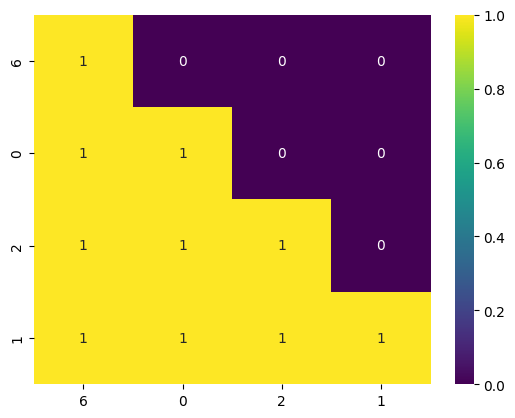

In [8]:
future_masks = future_masks.detach().cpu().squeeze().numpy() if isinstance(future_masks, torch.Tensor) else future_masks
input_ids = input_ids.detach().cpu().numpy() if isinstance(input_ids, torch.Tensor) else input_ids
sns.heatmap(future_masks, annot=True, cmap='viridis', xticklabels=input_ids, yticklabels=input_ids);

You see that first row the first token 6 can only attend to itself, and the
second row token 0 can attend to 6 and itself etc. Clearly it does not make much
sense here. We can already see that this problem implicitly can be framed as a
_sequence classification_ problem. Treat the `NUM_CLASSES=10` as the number of
vocabulary in a traditional decodeer problem, where you are tasked to pick the
next likely token in the 10 classes (digits) given the previous tokens. So if
you have 1 sample that is sequence length of 4 and num classes (vocab) of 10,
then this sample has a shape of $1 \times 4$ as input ids, and later the logits
will be of shape $1 \times 4 \times 10$. Correspondingly, the labels will be of
shape $1 \times 4$. And we can think of the logits as 4 rows, first row will be
the logits for the first token, second row will be the logits for the second
token etc. And the labels will be the ground truth for each token. So for each
row we choose the most likely token from the logits via `argmax` as our
predicted label. And so if we use causal mask, the first token 6 will never have
context of 0, 2 and 1 because they are in the future - and this is bad because
we actually want it to know that hey I am 6 and I want to predict the last token
in the full sequence (which is 1). We can simply fix this by removing the causal
mask, and now the first token 6 can attend to all the tokens in the sequence and
it can learn that hey I am 6 and I want to predict 1. And this is how we can
frame the problem as a sequence classification problem - or if you want to be
more pedantic, it also fits in the sequence to sequence paradigm with token
classification. Later we will visit a more typical sequence classification task.

## From Causal Mask To Cross-Attention Mask

We can see from our line 13 below that we mask the attention scores with
$-\infty$ whenever the `mask` tensor has a value of $0$.

```{code-block} md
---
linenos: true
emphasize-lines: 13
---

class ScaledDotProductAttention(Attention):
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.BoolTensor | None = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # fmt: off
        d_q               = query.size(dim=-1)

        attention_scores  = torch.matmul(query, key.transpose(dim0=-2, dim1=-1)) / torch.sqrt(torch.tensor(d_q).float())        # [B, H, T, d_q] @ [B, H, d_q, T] = [B, H, T, T]
        attention_scores  = attention_scores.masked_fill(mask == 0, float("-inf")) if mask is not None else attention_scores    # [B, H, T, T]

        attention_weights = attention_scores.softmax(dim=-1)        # [B, H, T, T]
        attention_weights = self.dropout(attention_weights)         # [B, H, T, T]

        context_vector    = torch.matmul(attention_weights, value)  # [B, H, T, T] @ [B, H, T, d_v] = [B, H, T, d_v]
        # fmt: on
        return context_vector, attention_weights
```

And the mask we pass into the `ScaledDotProductAttention` class is constructed
with lower triangular mask for each sequence in the batch as indicated in line 4
below. The lower triangular mask ensures the model does not attend to future
tokens.

```{code-block} md
---
linenos: true
emphasize-lines: 4
---

def construct_dummy_batch_future_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Broadcast future mask from shape (L, L) to (B, L, L) then (B, 1, L, L)."""
    # Create a lower triangular mask for a single sequence
    future_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=0).to(torch.bool)
    future_mask = future_mask.contiguous()
    # broadcast future mask from shape (L, L) to (B, L, L)
    future_masks = future_mask.unsqueeze(0).expand(batch_size, -1, -1)
    # broadcast future mask from shape (B, L, L) to (B, 1, L, L)
    future_masks = future_masks.unsqueeze(1)
    return torch.BoolTensor(future_masks)
```

However, in the context of fine-tuning decoder models from a classification
task, one way is we need to remove the restriction of the model not attending to
future tokens (not the only way as one can use context/last token pooling). This
is because the model needs to attend to all tokens in the sequence to make a
classification decision. For example, consider the sentiment of the sentence
`"I love this movie, it is so good"` to be positive, the model should
necessarily know the feature map of the whole sequence to make a decision.
Unlike decoder only variants, only having the last token `good` with full
contextual information with _every other_ token in the sequence is not
sufficient. For now, we will first replace the lower triangular mask with a full
mask of ones, essentially making the mask a non-causal mask because when we pass
in a mask of ones, the model will _not_ mask anything due to the condition
masking only 0 values (`mask == 0`) in line 13 above.

In [9]:
def construct_dummy_batch_cross_attention_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Broadcast mask from shape (L, L) to (B, L, L) then (B, 1, L, L)."""
    # Create a mask for a single sequence
    mask = torch.ones((seq_len, seq_len), dtype=torch.bool) # this is changed from future_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=0).to(torch.bool)

    mask = mask.contiguous()
    # broadcast mask from shape (L, L) to (B, L, L)
    masks = mask.unsqueeze(0).expand(batch_size, -1, -1)
    # broadcast mask from shape (B, L, L) to (B, 1, L, L)
    masks = masks.unsqueeze(1)
    return torch.BoolTensor(masks)

def collate_for_birectional(
    batch: List[Tuple[torch.Tensor, torch.Tensor]]
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    sources, targets = zip(*batch)

    sources = torch.stack(sources)
    targets = torch.stack(targets)

    batch_size, seq_len = targets.size(0), targets.size(1)

    cross_attention_masks = construct_dummy_batch_cross_attention_masks(batch_size, seq_len)
    target_padding_masks = construct_dummy_batch_target_padding_masks(batch_size, seq_len)

    return sources, targets, cross_attention_masks, target_padding_masks

In [10]:
seed_all(seed=42, seed_torch=True, set_torch_deterministic=False)

SEQ_LEN, NUM_CLASSES, BATCH_SIZE = 16, 10, 128
TRAIN_SAMPLES, VALID_SAMPLES     = 50000, 10000

dataset      = partial(ReverseDataset, num_classes=NUM_CLASSES, seq_len=SEQ_LEN)
train_loader = DataLoader(dataset(num_samples=TRAIN_SAMPLES), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, collate_fn=collate_for_birectional)
valid_loader = DataLoader(dataset(num_samples=VALID_SAMPLES), batch_size=BATCH_SIZE, collate_fn=collate_for_birectional)

collated_batch = next(iter(train_loader))

print(f"Sources: {collated_batch[0].size()}\nTargets: {collated_batch[1].size()}\nFuture Masks: {collated_batch[2].size()}\nTarget Padding Masks: {collated_batch[3].size()}")

Sources: torch.Size([128, 16])
Targets: torch.Size([128, 16])
Future Masks: torch.Size([128, 1, 16, 16])
Target Padding Masks: torch.Size([128, 1, 16, 16])


In [11]:
collated_batch[0][0], collated_batch[1][0]

(tensor([4, 2, 7, 6, 1, 3, 8, 6, 9, 3, 3, 0, 8, 0, 9, 3]),
 tensor([3, 9, 0, 8, 0, 3, 3, 9, 6, 8, 3, 1, 6, 7, 2, 4]))

## Modifying GPT-2 Head For Classification

We are clear that the pre-head layer (backbone) consist of the transformer
decoder stack, and it is clear that the output of this stack is a tensor of
shape $\mathcal{B} \times T \times D$ where $\mathcal{B}$ is the batch size, $T$
is the sequence length, and $D$ is the hidden dimension of the model.

We can think of the backbone as a feature extractor, and the head layer as
a classifier.

From

```python
self.head: nn.Linear = nn.Linear(config.d_model, config.vocab_size)  # last layer
```

to

```python
self.head = nn.Sequential(
    nn.Linear(config.d_model, config.d_model),
    nn.LayerNorm(config.d_model),
    nn.ReLU(inplace=True),
    nn.Dropout(config.dropout),
    nn.Linear(config.d_model, NUM_CLASSES)
)
```

Or more simply,

```python
base_model = GPTDecoder(config)
head = nn.Sequential(
    nn.Linear(config.d_model, config.d_model),
    nn.LayerNorm(config.d_model),
    nn.ReLU(inplace=True),
    nn.Dropout(config.dropout),
    nn.Linear(config.d_model, NUM_CLASSES)
)
base_model.head = head
```

this works too but note that if you want some super custom weight initialization
then you might want to initialize the weights of the head layer separately. Also
, practioners typically call a base model without its head the _backbone_. It is
also worth noting that there is no need to define the `head` as such, a simple
`nn.Linear` layer will suffice, but the above implementation is from a legacy
habit of mine.

In [13]:
class DecoderForSequenceClassificationConfig(DecoderConfig):
    num_labels: int

class GPTDecoderReverse(GPTDecoder):
    def __init__(self, config: DecoderForSequenceClassificationConfig) -> None:
        super().__init__(config)
        # fmt: off
        self.head = nn.Sequential(
            nn.Linear(config.d_model, config.d_model),
            nn.LayerNorm(config.d_model),
            nn.ReLU(inplace=True),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_model, config.num_labels)
        )
        # fmt: on

        self.apply(self._init_weights)

        # apply special scaled init to the residual projections, per GPT-2 paper
        for parameter_name, parameter in self.named_parameters():
            if parameter_name.endswith("context_projection.weight"):
                mean = 0.0
                std_dev = 0.02 / torch.sqrt(torch.tensor(2 * config.num_decoder_blocks, dtype=torch.float))
                torch.nn.init.normal_(parameter, mean=mean, std=std_dev)

## Callback

In [14]:
@torch.no_grad()
def evaluate_on_reverse_dataset(trainer: Trainer, num_batches_to_eval: int | None = None) -> None:
    model = trainer.model
    model.eval()

    dataloader = trainer.valid_loader
    assert dataloader is not None

    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(dataloader, start=1), desc="Evaluating on Reverse Dataset", leave=False)
    for batch_index, (inputs, labels, target_padding_masks, future_masks) in progress_bar:
        inputs, labels = inputs.to(trainer.device), labels.to(trainer.device)
        target_padding_masks = target_padding_masks.to(trainer.device)
        future_masks = future_masks.to(trainer.device)

        logits = model(inputs, target_padding_masks=target_padding_masks, future_masks=future_masks) # [128, 16, 10]
        predictions = logits.argmax(dim=-1) # [128, 16]

        total_correct += (predictions == labels).float().sum().item()
        total_samples += labels.numel()

        if num_batches_to_eval and batch_index >= num_batches_to_eval:
            print("Early stopping evaluation.")
            break

    overall_accuracy = total_correct / total_samples
    trainer.state.history["valid_accuracy"].append(overall_accuracy)
    trainer.logger.info("Overall Accuracy on Reverse Dataset %s", overall_accuracy)

## Training

In [15]:
masked_self_attention_mha_config = MultiHeadedAttentionConfig(
    attention=ScaledDotProductAttention(), d_model=32, H=1, dropout=0.0
)

feed_forward_config = PositionwiseFeedForwardConfig(
    d_model=32, d_ff=32 * 2, activation=nn.GELU(approximate="tanh"), dropout=0.0, bias=True
)

add_norm_config_1 = AddNormConfig(feature_dim=32, dropout=0.0)
add_norm_config_2 = AddNormConfig(feature_dim=32, dropout=0.0)

decoder_block_config = DecoderBlockConfig(
    masked_self_attention_mha=masked_self_attention_mha_config,
    feed_forward=feed_forward_config,
    add_norm_1=add_norm_config_1,
    add_norm_2=add_norm_config_2,
)

model_config = DecoderForSequenceClassificationConfig(
    d_model=32,
    vocab_size=NUM_CLASSES,
    context_length=SEQ_LEN,
    num_decoder_blocks=1,
    dropout=0.0,
    decoder_block=decoder_block_config,
    num_labels=NUM_CLASSES,
)

optimizer_config_cls = OPTIMIZER_REGISTRY["torch.optim.Adam"]
optimizer_pydantic_config = optimizer_config_cls(name="torch.optim.Adam", lr=4e-3)

criterion_config_cls = CRITERION_REGISTRY["torch.nn.CrossEntropyLoss"]
criterion_pydantic_config = criterion_config_cls(name="torch.nn.CrossEntropyLoss")

scheduler_config_cls = SCHEDULER_REGISTRY["torch.optim.lr_scheduler.CosineAnnealingLR"]
scheduler_pydantic_config = scheduler_config_cls(name="torch.optim.lr_scheduler.CosineAnnealingLR", T_max=10)

trainer_config = TrainerConfig(
    device="cpu",
    max_epochs=1,
    eval_every_n_steps=10000,
    log_every_n_steps=10000,
    use_amp=False,
    autocast_config={"enabled": False, "dtype": None, "cache_enabled": None},
    scaler_config={
        "enabled": False,
        "init_scale": 2.0**16,
        "growth_factor": 2.0,
        "backoff_factor": 0.5,
        "growth_interval": 2000,
    },
    gradient_accumulation_steps=1,
    clip_grad_norm={"max_norm": 1.0, "norm_type": 2.0, "error_if_nonfinite": False, "foreach": None},
    apply_weight_decay_to_different_param_groups=False,
    step_scheduler_on_batch_or_epoch="epoch",
    save_dir="./data/reversal/checkpoints",
    save_every_epoch=False,
    save_best_only=True,
    monitor="valid_this_epoch_average_loss",
    mode="min",
)
generator_config = GeneratorConfig(temperature=1.0, max_tokens=SEQ_LEN, greedy=False, top_k=10, top_p=None)

composer = Composer(
    model=model_config,
    optimizer=optimizer_pydantic_config,
    criterion=criterion_pydantic_config,
    scheduler=scheduler_pydantic_config,
    trainer=trainer_config,
    generator=generator_config,
)

In [16]:
model = GPTDecoderReverse(model_config).to(composer.trainer.device)
optimizer = optimizer_pydantic_config.build(params=model.parameters())
criterion = criterion_pydantic_config.create_instance()

composer.scheduler = scheduler_pydantic_config
scheduler = scheduler_pydantic_config.build(optimizer=optimizer)

composer.pretty_print()

state = State(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
)

device = composer.trainer.device

trainer = Trainer(
    state=state,
    composer=composer,
    logger=None,
    device=device,  # type: ignore[arg-type]
)

trainer.add_callback(
    TrainerEvent.ON_VALID_EPOCH_END.value,
    lambda trainer: evaluate_on_reverse_dataset(trainer, num_batches_to_eval=None),
)

Composer(
│   constants=MaybeConstant(),
│   logger=LoggerConfig(
│   │   log_file=None,
│   │   module_name=None,
│   │   propagate=False,
│   │   log_root_dir=None,
│   │   rich_handler_config={
│   │   │   'level': 'INFO',
│   │   │   'console': MISSING,
│   │   │   'show_level': True,
│   │   │   'show_path': True,
│   │   │   'show_time': True,
│   │   │   'rich_tracebacks': True,
│   │   │   'markup': True,
│   │   │   'log_time_format': '[%Y-%m-%d %H:%M:%S]'
│   │   }
│   ),
│   global_=MaybeGlobal(seed=42, debug=False, debug_samples=256),
│   data=DataConfig(
│   │   context_length=128,
│   │   dataset_name=None,
│   │   dataset_size=2,
│   │   dataset_path=None,
│   │   dataset_dir=None,
│   │   dataset_url=None,
│   │   split=[0.7, 0.1, 0.2],
│   │   collate_fn={'batch_first': True, 'pad_token_id': 16},
│   │   train_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': True,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   },
│   │   valid_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': False,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   },
│   │   test_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': False,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   }
│   ),
│   model=DecoderForSequenceClassificationConfig(
│   │   d_model=32,
│   │   vocab_size=10,
│   │   context_length=16,
│   │   num_decoder_blocks=1,
│   │   dropout=0.0,
│   │   decoder_block=DecoderBlockConfig(
│   │   │   masked_self_attention_mha=MultiHeadedAttentionConfig(
│   │   │   │   attention=ScaledDotProductAttention(
  (dropout): Dropout(p=0.0, inplace=False)
),
│   │   │   │   d_model=32,
│   │   │   │   H=1,
│   │   │   │   dropout=0.0
│   │   │   ),
│   │   │   feed_forward=PositionwiseFeedForwardConfig(
│   │   │   │   d_model=32,
│   │   │   │   d_ff=64,
│   │   │   │   activation=GELU(approximate='tanh'),
│   │   │   │   dropout=0.0,
│   │   │   │   bias=True
│   │   │   ),
│   │   │   add_norm_1=AddNormConfig(feature_dim=32, dropout=0.0),
│   │   │   add_norm_2=AddNormConfig(feature_dim=32, dropout=0.0)
│   │   ),
│   │   num_labels=10
│   ),
│   optimizer=AdamConfig(name='torch.optim.Adam', lr=0.004, betas=(0.9, 0.98), eps=1e-09, weight_decay=0.0),
│   criterion=CrossEntropyLossConfig(
│   │   name='torch.nn.CrossEntropyLoss',
│   │   weight=None,
│   │   size_average=None,
│   │   ignore_index=-100,
│   │   reduction='mean',
│   │   label_smoothing=0.0
│   ),
│   scheduler=CosineAnnealingLRConfig(
│   │   name='torch.optim.lr_scheduler.CosineAnnealingLR',
│   │   T_max=10,
│   │   eta_min=0,
│   │   last_epoch=-1,
│   │   verbose=False
│   ),
│   trainer=TrainerConfig(
│   │   device=device(type='cpu'),
│   │   max_epochs=1,
│   │   log_every_n_steps=10000,
│   │   eval_every_n_steps=10000,
│   │   step_scheduler_on_batch_or_epoch='epoch',
│   │   use_amp=False,
│   │   autocast_config={'enabled': False, 'dtype': None, 'cache_enabled': None},
│   │   scaler_config={
│   │   │   'enabled': False,
│   │   │   'init_scale': 65536.0,
│   │   │   'growth_factor': 2.0,
│   │   │   'backoff_factor': 0.5,
│   │   │   'growth_interval': 2000
│   │   },
│   │   gradient_accumulation_steps=1,
│   │   clip_grad_norm={'max_norm': 1.0, 'norm_type': 2.0, 'error_if_nonfinite': False, 'foreach': None},
│   │   apply_weight_decay_to_different_param_groups=False,
│   │   save_dir='./data/reversal/checkpoints/2024-07-17_21-17-05',
│   │   save_every_epoch=False,
│   │   save_best_only=True,
│   │   monitor='valid_this_epoch_average_loss',
│   │   mode='min'
│   ),
│   generator=GeneratorConfig(max_tokens=16, temperature=1.0, greedy=False, top_k=10, top_p=None),
│   distributed=DistributedConfig(
│   │   log_dir='logs_distributed',
│   │   log_level=20,
│   │   log_on_master_or_all=True,
│   │   master_addr='localhost',
│   │   master_port='29500',
│   │   nno

In [17]:
_trained_state = trainer.fit(train_loader=train_loader, valid_loader=valid_loader)
clear_output(wait=False)

In [18]:
print(f"Accuracies={_trained_state.history['valid_accuracy']}.")

Accuracies=[1.0].


## Attention Heatmap

In [19]:
last_decoder_block = _trained_state.model.decoder_blocks[-1]
pprint(last_decoder_block)

masked_self_attention_mha = last_decoder_block.masked_self_attention_mha
context_vector, attention_weights = masked_self_attention_mha.context_vector, masked_self_attention_mha.attention_weights

num_heads = attention_weights.size(1)

print("Context vector shape:", context_vector.size())
print("Attention weights shape:", attention_weights.size())
print("Number of heads:", num_heads)

GPTDecoderBlock(
  (masked_self_attention_mha): MultiHeadedAttention(
│   (W_Q): Linear(in_features=32, out_features=32, bias=False)
│   (W_K): Linear(in_features=32, out_features=32, bias=False)
│   (W_V): Linear(in_features=32, out_features=32, bias=False)
│   (W_O): Linear(in_features=32, out_features=32, bias=False)
│   (attention): ScaledDotProductAttention(
│     (dropout): Dropout(p=0.0, inplace=False)
│   )
│   (dropout): Dropout(p=0.0, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
│   (ffn): ModuleDict(
│     (context_fc): Linear(in_features=32, out_features=64, bias=True)
│     (activation): GELU(approximate='tanh')
│     (context_projection): Linear(in_features=64, out_features=32, bias=True)
│     (dropout): Dropout(p=0.0, inplace=False)
│   )
  )
  (add_norm_1): AddNorm(
│   (dropout): Dropout(p=0.0, inplace=False)
│   (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (add_norm_2): AddNorm(
│   (dropout): Dropout(p=0.0, inplace=False)
│   (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
)

Context vector shape: torch.Size([16, 1, 16, 32])
Attention weights shape: torch.Size([16, 1, 16, 16])
Number of heads: 1


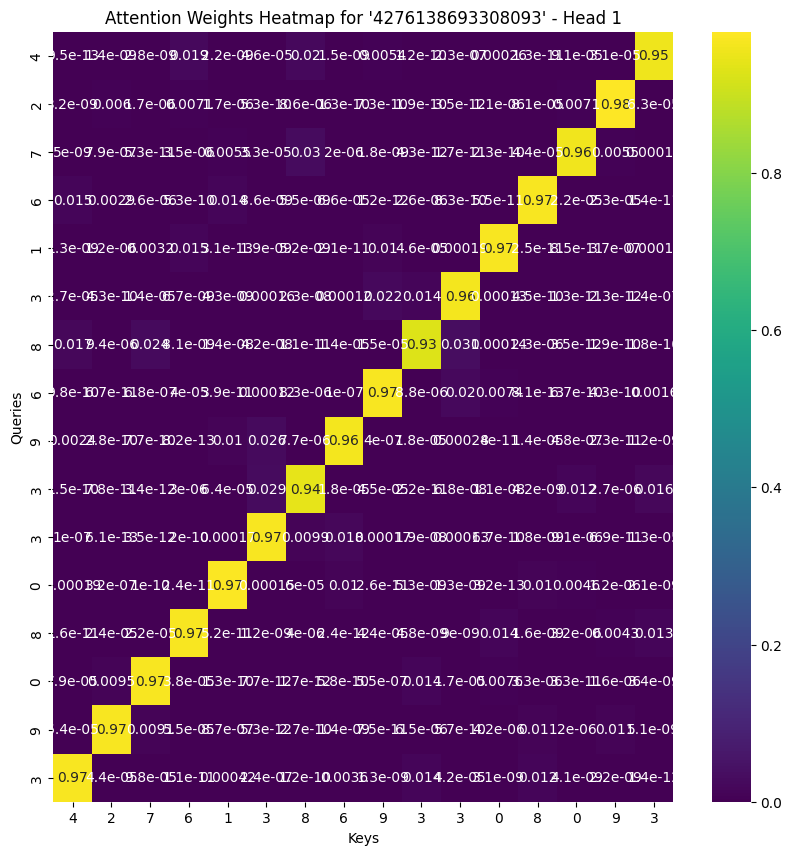

In [20]:
# Input data: [4, 2, 7, 6, 1, 3, 8, 6, 9, 3, 3, 0, 8, 0, 9, 3]
# Labels:     [3, 9, 0, 8, 0, 3, 3, 9, 6, 8, 3, 1, 6, 7, 2, 4]

input = "4276138693308093"
label = input[::-1]

for head in range(num_heads):
    plt.figure(figsize=(10, 10))

    attention_matrix = attention_weights[-1, head, :, :].detach().numpy()

    sns.heatmap(attention_matrix, annot=True, cmap='viridis', xticklabels=input, yticklabels=input)
    plt.title(f"Attention Weights Heatmap for '{input}' - Head {head+1}")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()


The heatmap diagonal is correct because in the above image, we can
treat it as a $T \times T$  matrix, where the first row is the first token from query,
interacting with every other token as keys. So if first token is 2 and last token is 8,
then it should be matching each other because of the "reversal".

## How About We Use Back Causal Attention Mask?

Let's see what happens if we did not use cross-attention mask, but instead used
back causal attention mask.

In [21]:
seed_all(seed=42, seed_torch=True, set_torch_deterministic=False)

SEQ_LEN, NUM_CLASSES, BATCH_SIZE = 16, 10, 128
TRAIN_SAMPLES, VALID_SAMPLES     = 50000, 10000

dataset      = partial(ReverseDataset, num_classes=NUM_CLASSES, seq_len=SEQ_LEN)
train_loader = DataLoader(dataset(num_samples=TRAIN_SAMPLES), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, collate_fn=collate_for_unidirectional)
valid_loader = DataLoader(dataset(num_samples=VALID_SAMPLES), batch_size=BATCH_SIZE, collate_fn=collate_for_unidirectional)

collated_batch = next(iter(train_loader))

print(f"Sources: {collated_batch[0].size()}\nTargets: {collated_batch[1].size()}\nFuture Masks: {collated_batch[2].size()}\nTarget Padding Masks: {collated_batch[3].size()}")

Sources: torch.Size([128, 16])
Targets: torch.Size([128, 16])
Future Masks: torch.Size([128, 1, 16, 16])
Target Padding Masks: torch.Size([128, 1, 16, 16])


In [22]:
model = GPTDecoderReverse(model_config).to(composer.trainer.device)
optimizer = optimizer_pydantic_config.build(params=model.parameters())
criterion = criterion_pydantic_config.create_instance()

composer.scheduler = scheduler_pydantic_config
scheduler = scheduler_pydantic_config.build(optimizer=optimizer)

composer.pretty_print()

state = State(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
)

device = composer.trainer.device

trainer = Trainer(
    state=state,
    composer=composer,
    logger=None,
    device=device,  # type: ignore[arg-type]
)

trainer.add_callback(
    TrainerEvent.ON_VALID_EPOCH_END.value,
    lambda trainer: evaluate_on_reverse_dataset(trainer, num_batches_to_eval=None),
)

Composer(
│   constants=MaybeConstant(),
│   logger=LoggerConfig(
│   │   log_file=None,
│   │   module_name=None,
│   │   propagate=False,
│   │   log_root_dir=None,
│   │   rich_handler_config={
│   │   │   'level': 'INFO',
│   │   │   'console': MISSING,
│   │   │   'show_level': True,
│   │   │   'show_path': True,
│   │   │   'show_time': True,
│   │   │   'rich_tracebacks': True,
│   │   │   'markup': True,
│   │   │   'log_time_format': '[%Y-%m-%d %H:%M:%S]'
│   │   }
│   ),
│   global_=MaybeGlobal(seed=42, debug=False, debug_samples=256),
│   data=DataConfig(
│   │   context_length=128,
│   │   dataset_name=None,
│   │   dataset_size=2,
│   │   dataset_path=None,
│   │   dataset_dir=None,
│   │   dataset_url=None,
│   │   split=[0.7, 0.1, 0.2],
│   │   collate_fn={'batch_first': True, 'pad_token_id': 16},
│   │   train_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': True,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   },
│   │   valid_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': False,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   },
│   │   test_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': False,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   }
│   ),
│   model=DecoderForSequenceClassificationConfig(
│   │   d_model=32,
│   │   vocab_size=10,
│   │   context_length=16,
│   │   num_decoder_blocks=1,
│   │   dropout=0.0,
│   │   decoder_block=DecoderBlockConfig(
│   │   │   masked_self_attention_mha=MultiHeadedAttentionConfig(
│   │   │   │   attention=ScaledDotProductAttention(
  (dropout): Dropout(p=0.0, inplace=False)
),
│   │   │   │   d_model=32,
│   │   │   │   H=1,
│   │   │   │   dropout=0.0
│   │   │   ),
│   │   │   feed_forward=PositionwiseFeedForwardConfig(
│   │   │   │   d_model=32,
│   │   │   │   d_ff=64,
│   │   │   │   activation=GELU(approximate='tanh'),
│   │   │   │   dropout=0.0,
│   │   │   │   bias=True
│   │   │   ),
│   │   │   add_norm_1=AddNormConfig(feature_dim=32, dropout=0.0),
│   │   │   add_norm_2=AddNormConfig(feature_dim=32, dropout=0.0)
│   │   ),
│   │   num_labels=10
│   ),
│   optimizer=AdamConfig(name='torch.optim.Adam', lr=0.004, betas=(0.9, 0.98), eps=1e-09, weight_decay=0.0),
│   criterion=CrossEntropyLossConfig(
│   │   name='torch.nn.CrossEntropyLoss',
│   │   weight=None,
│   │   size_average=None,
│   │   ignore_index=-100,
│   │   reduction='mean',
│   │   label_smoothing=0.0
│   ),
│   scheduler=CosineAnnealingLRConfig(
│   │   name='torch.optim.lr_scheduler.CosineAnnealingLR',
│   │   T_max=10,
│   │   eta_min=0,
│   │   last_epoch=-1,
│   │   verbose=False
│   ),
│   trainer=TrainerConfig(
│   │   device=device(type='cpu'),
│   │   max_epochs=1,
│   │   log_every_n_steps=10000,
│   │   eval_every_n_steps=10000,
│   │   step_scheduler_on_batch_or_epoch='epoch',
│   │   use_amp=False,
│   │   autocast_config={'enabled': False, 'dtype': None, 'cache_enabled': None},
│   │   scaler_config={
│   │   │   'enabled': False,
│   │   │   'init_scale': 65536.0,
│   │   │   'growth_factor': 2.0,
│   │   │   'backoff_factor': 0.5,
│   │   │   'growth_interval': 2000
│   │   },
│   │   gradient_accumulation_steps=1,
│   │   clip_grad_norm={'max_norm': 1.0, 'norm_type': 2.0, 'error_if_nonfinite': False, 'foreach': None},
│   │   apply_weight_decay_to_different_param_groups=False,
│   │   save_dir='./data/reversal/checkpoints/2024-07-17_21-17-05',
│   │   save_every_epoch=False,
│   │   save_best_only=True,
│   │   monitor='valid_this_epoch_average_loss',
│   │   mode='min'
│   ),
│   generator=GeneratorConfig(max_tokens=16, temperature=1.0, greedy=False, top_k=10, top_p=None),
│   distributed=DistributedConfig(
│   │   log_dir='logs_distributed',
│   │   log_level=20,
│   │   log_on_master_or_all=True,
│   │   master_addr='localhost',
│   │   master_port='29500',
│   │   nno

In [23]:
_trained_state = trainer.fit(train_loader=train_loader, valid_loader=valid_loader)
clear_output(wait=False)

The accuracy now is 55 percent.

In [24]:
print(f"Accuracies={_trained_state.history['valid_accuracy']}.")

Accuracies=[0.54976875].


In [25]:
last_decoder_block = _trained_state.model.decoder_blocks[-1]
pprint(last_decoder_block)

masked_self_attention_mha = last_decoder_block.masked_self_attention_mha
context_vector, attention_weights = masked_self_attention_mha.context_vector, masked_self_attention_mha.attention_weights

num_heads = attention_weights.size(1)

print("Context vector shape:", context_vector.size())
print("Attention weights shape:", attention_weights.size())
print("Number of heads:", num_heads)

GPTDecoderBlock(
  (masked_self_attention_mha): MultiHeadedAttention(
│   (W_Q): Linear(in_features=32, out_features=32, bias=False)
│   (W_K): Linear(in_features=32, out_features=32, bias=False)
│   (W_V): Linear(in_features=32, out_features=32, bias=False)
│   (W_O): Linear(in_features=32, out_features=32, bias=False)
│   (attention): ScaledDotProductAttention(
│     (dropout): Dropout(p=0.0, inplace=False)
│   )
│   (dropout): Dropout(p=0.0, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
│   (ffn): ModuleDict(
│     (context_fc): Linear(in_features=32, out_features=64, bias=True)
│     (activation): GELU(approximate='tanh')
│     (context_projection): Linear(in_features=64, out_features=32, bias=True)
│     (dropout): Dropout(p=0.0, inplace=False)
│   )
  )
  (add_norm_1): AddNorm(
│   (dropout): Dropout(p=0.0, inplace=False)
│   (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (add_norm_2): AddNorm(
│   (dropout): Dropout(p=0.0, inplace=False)
│   (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
)

Context vector shape: torch.Size([16, 1, 16, 32])
Attention weights shape: torch.Size([16, 1, 16, 16])
Number of heads: 1


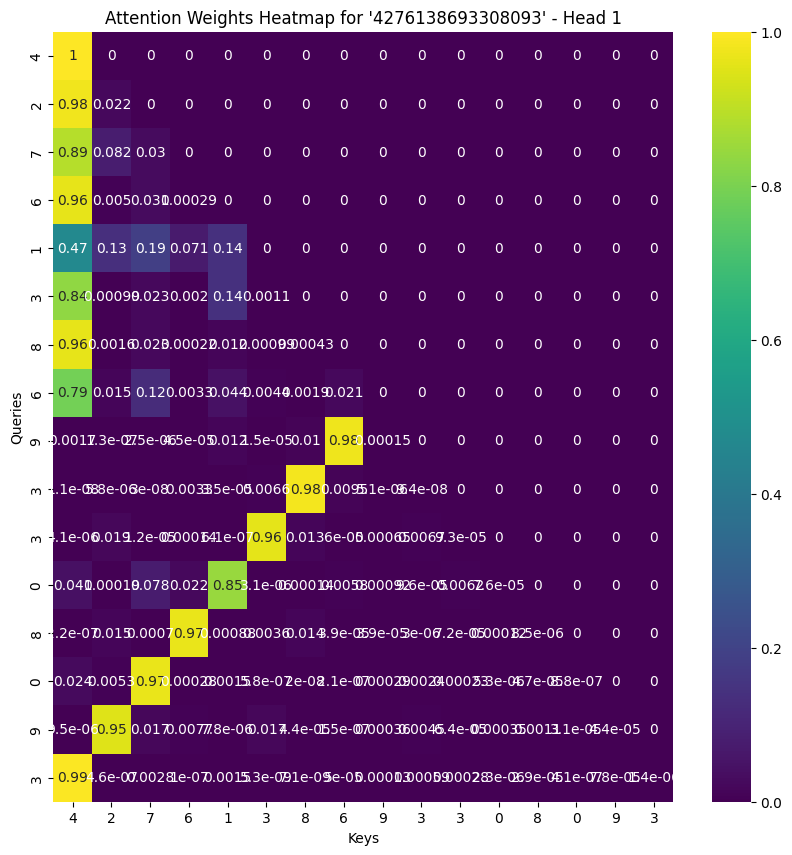

In [26]:
# Input data: [4, 2, 7, 6, 1, 3, 8, 6, 9, 3, 3, 0, 8, 0, 9, 3]
# Labels:     [3, 9, 0, 8, 0, 3, 3, 9, 6, 8, 3, 1, 6, 7, 2, 4]

input = "4276138693308093"
label = input[::-1]

for head in range(num_heads):
    plt.figure(figsize=(10, 10))

    attention_matrix = attention_weights[-1, head, :, :].detach().numpy()

    sns.heatmap(attention_matrix, annot=True, cmap='viridis', xticklabels=input, yticklabels=input)
    plt.title(f"Attention Weights Heatmap for '{input}' - Head {head+1}")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()


Recall that earlier the accuracy is 55 percent, one can also tell the attention
mask is getting only half "correct". Rightfully so, because say from the image
above,from token 9 onwards, it can see its reverse token, which is 6 here,
whereas for 6, it cannot see 9, so it cannot predict 9 properly.